In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV

from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier

from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

from sklearn.neural_network import MLPRegressor,MLPClassifier

from xgboost import XGBClassifier, XGBRegressor

import warnings 
warnings.filterwarnings('ignore')

import datetime as dt



from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
p = matplotlib.rcParams
p["font.size"] = 25
p["axes.unicode_minus"] = False
p['lines.linewidth'] = 3
p['pdf.fonttype'] = 42
p['ps.fonttype'] = 42
p["figure.figsize"] = [9, 6]
p['grid.color'] = 'k'
p['grid.linestyle'] = ':'
p['grid.linewidth'] = 0.5
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 3)) #n: number of the lines you want to plot 
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
features = pd.read_csv('spx_cons_norm.csv')
features = features[['datadate','industry_id','forward_excess_ret','binary_class','multi_class','tic',
                     'abnormal_volume', 'MA3', 'MA6', 'MA12', 'EMA3', 'EMA6', 'EMA12',
                    'NI_growth', 'Size', 'PriceCap', 'ROE', 'ROA', 'ROI', 'NetPM',
                   'epspi12', 'earnings', 'earningsVol', 'Asset Turnover', 'PE', 'PB',
                   'PS', 'dividend_yield', 'ev_ebitda', 'NCFP']]
industry_dummy = pd.get_dummies(features['industry_id'])
features = pd.merge(features,industry_dummy,how='left',left_index=True,right_index=True)

features = features.dropna(subset=['forward_excess_ret','binary_class','multi_class'])
features_after = features.groupby(['tic']).ffill()
features_after = pd.merge(features_after,features[['tic']],how='left',left_index=True,right_index=True)

cols = [col for col in features_after.columns if col not in ['datadate','industry_id','forward_excess_ret','binary_class','multi_class','tic']]
df_na = features_after.isnull()

df_mean = features_after.groupby('tic').mean()

In [3]:
for col in cols:
    na_series = features_after[col].isnull()
    names = list(features_after.loc[na_series,'tic'])     

    t = df_mean.loc[names,col]
    t.index = features_after.loc[na_series,col].index

    
    features_after.loc[na_series,col] = t



for col in cols:
    na_series = features_after[col].isnull()
    mean = np.mean(features_after[col]) 
    features_after.loc[na_series,col] = mean

In [4]:
features_after['up_down'] = features_after['forward_excess_ret'].apply(lambda x: int(x>0))

## Backtest
### Rolling
Use the past 12 months(if there are not 12 months in the past, use all the historical data) as the test set to train our model. Then apply the trained model on every month on a rolling basis.

Every month, long the top 10% (aboout 50 stocks) with the higheset predicted excess returns and short the bottom 10% that are predicted to gain the lowest returns.


Calculate the cumulative returns over time: 

$r_t = \frac{1}{n}\sum_i^n r_{long} -  \frac{1}{n}\sum_i^n r_{short}$

$Cumulative\_Return_T = \sum_i^T r_t$

In [5]:
def long_quantile(data):
    return(data[data['pred']>=data['pred'].quantile(0.9)])
    
def short_quantile(data):
    return(data[data['pred']<=data['pred'].quantile(0.1)])

def group_precision(df,keyword):
    temp = df.groupby(by=[keyword,'pred_class']).size().reset_index()
    temp.columns=['True','Predict','Size']
    temp = temp.pivot(index='True',columns='Predict',values='Size')
    return(temp)

In [6]:
def backtest_rolling(df,model,keyword):    
    # df should be a cleaned dataframe with all factors and datadate
    # model is the regression model initialized(no warm start)
    # keyword can be forward_excess_ret, binary_class, multi_class and up_down
    feature_names=['MA3','MA12','Size','ROI','PS','ev_ebitda','earningsVol','dividend_yield','epspi12']
    
    p = pd.DataFrame()
    datelist = list(df['datadate'].drop_duplicates())
    precision = pd.DataFrame()
    for m in range(2,len(datelist)):
        date_range = datelist[max(0,m-12):m-1]
        train = df[df.datadate.isin(date_range)]
        X_train = train[feature_names]
        y_train = train[keyword]
        test = df[df.datadate==datelist[m]]
        X_test = test[feature_names]
        y_test = test[keyword]
        
        model = model.fit(X_train,y_train)

        if keyword == 'forward_excess_ret' or keyword == 'multi_class':
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            train['pred'] = y_train_pred
            test['pred'] = y_test_pred
        else:
            y_train_pred = model.predict_proba(X_train)
            y_test_pred = model.predict_proba(X_test)
            train['pred'] = y_train_pred[:,1]
            test['pred'] = y_test_pred[:,1]
                                         
        
        
        
        
        if keyword == 'forward_excess_ret':
            1
        else:
            test['pred_class'] = test['pred'].apply(lambda x:round(x))            
            test['precision'] = (test['pred_class']-test[keyword]).apply(lambda x: int(x==0))
            precision = precision.append(test[['pred_class',keyword]])
        
        if keyword == 'multi_class':
            long = test[test.pred==9]
            short = test[test.pred==0]
        else:
            long = test.groupby(by=['datadate']).apply(long_quantile).reset_index(drop=True)
            short = test.groupby(by=['datadate']).apply(short_quantile).reset_index(drop=True)

        portfolio = long.groupby(by=['datadate'])['forward_excess_ret'].mean().reset_index()
        portfolio.columns = ['datadate','long_ret']
        temp = short.groupby(by=['datadate'])['forward_excess_ret'].mean().reset_index()
        temp.columns=['datadate','short_ret']
        portfolio = pd.merge(portfolio,temp)
        portfolio['ret'] = (portfolio['long_ret'] - portfolio['short_ret'])
        try:
            portfolio['precision'] = test['precision'].mean()
        except:
            1
        portfolio.index = portfolio['datadate'].apply(lambda x: dt.datetime.strptime(str(x),'%Y%m%d'))        
        
        p = p.append(portfolio)
        
    p['cum_ret'] = p['ret'].cumsum()+1

    plt.plot(p['cum_ret'],label='cumulative return')
    plt.legend()
    plt.show()
    
    
    if keyword == 'forward_excess_ret':
        1
    else:    
        plt.plot(p['precision'],label='precision',color=colors[0])
        plt.legend()
        plt.show()
        
        print('Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)')
        precision = group_precision(precision,keyword)
        sns.heatmap(precision,annot=True, fmt="d",cmap="YlGnBu")
        plt.show()
        
    
    annual_ret = p['ret'].mean()*12
    annual_std = p['ret'].std()*np.sqrt(12)
    
    ret = list(p['cum_ret'])
    max_drawdown = 2
    for i in range(2,len(ret)):
        temp = min(ret[:i-1])
        max_drawdown = min(temp/ret[i],max_drawdown)
    max_drawdown = 1-max_drawdown
        

    print('Annual_ret:',annual_ret,'\n')
    print('Sharpe Ratio:',annual_ret/annual_std,'\n')
    print('Max_drawdown:',max_drawdown)
    
    return(p)

### Rolling-based Model Comparison
#### Regressor

Lasso:


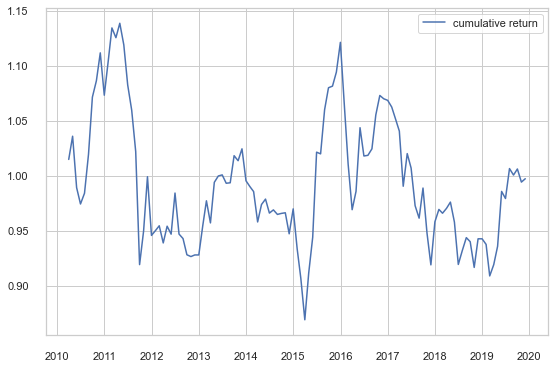

Annual_ret: -0.00028195065336081965 

Sharpe Ratio: -0.002933646140176081 

Max_drawdown: 0.22493938495317634
KNN:


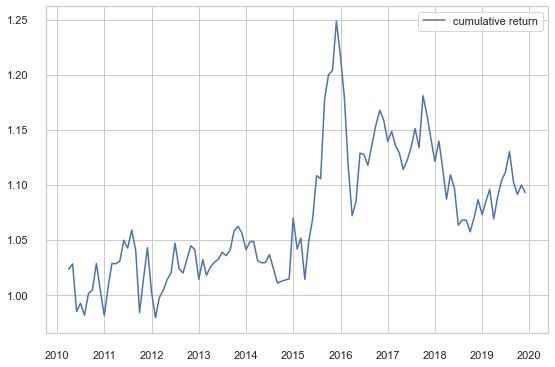

Annual_ret: 0.009520012190348063 

Sharpe Ratio: 0.12211347414503552 

Max_drawdown: 0.2158565727920917
DTs:


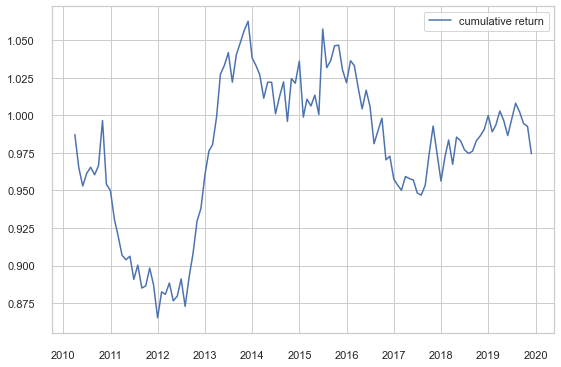

Annual_ret: -0.0026137544413346032 

Sharpe Ratio: -0.04961136000692052 

Max_drawdown: 0.1858388601472123
Adaboost:


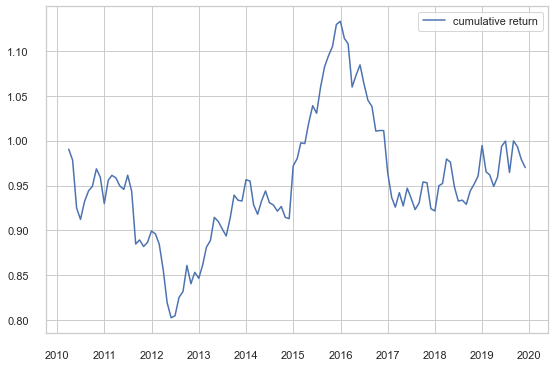

Annual_ret: -0.003071757105433951 

Sharpe Ratio: -0.0445424404772403 

Max_drawdown: 0.2916823559343904
Random Forest: 


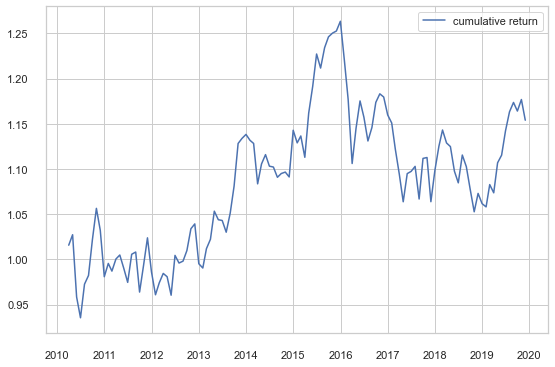

Annual_ret: 0.015792323701693856 

Sharpe Ratio: 0.17727801378177324 

Max_drawdown: 0.25950659874989757
XGBoost:
[10:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now

[10:59:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:59:57] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

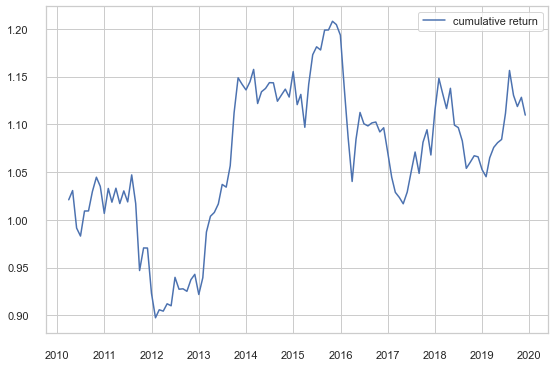

Annual_ret: 0.011247207145792406 

Sharpe Ratio: 0.13927210348137556 

Max_drawdown: 0.2570379833241675
Gradient Boost:


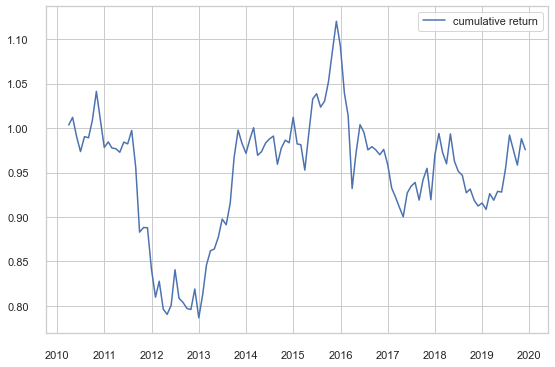

Annual_ret: -0.0025031949957352033 

Sharpe Ratio: -0.029550943377119235 

Max_drawdown: 0.29779200543457673
MLP:


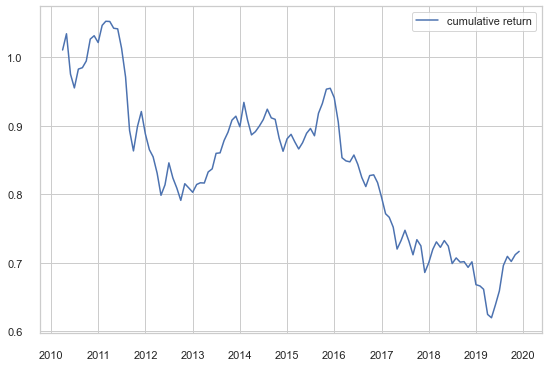

Annual_ret: -0.029044985539519536 

Sharpe Ratio: -0.4010477568651191 

Max_drawdown: 0.171367228111036


In [8]:
print('Lasso:')
model = LassoCV(cv=5,fit_intercept=True,alphas=np.linspace(0.00001,0.001,100)) 
p_lasso = backtest_rolling(features_after,model,keyword='forward_excess_ret')

print("KNN:")
knn = KNeighborsRegressor(n_neighbors=50)
p_knn = backtest_rolling(features_after,knn,keyword='forward_excess_ret')

print('DTs:')
tree = DecisionTreeRegressor(random_state=0)
p_tree = backtest_rolling(features_after,tree,keyword='forward_excess_ret')

print('Adaboost:')
model = AdaBoostRegressor(random_state=0, n_estimators=100)
p_ada = backtest_rolling(features_after,model,keyword='forward_excess_ret')

print('Random Forest: ')
model = RandomForestRegressor(max_depth=4, n_estimators=100, max_features='auto')
p_rf = backtest_rolling(features_after,model,keyword='forward_excess_ret')

print('XGBoost:')
model = XGBRegressor()
p_xgb = backtest_rolling(features_after,model,keyword='forward_excess_ret')

print('Gradient Boost:')
model = GradientBoostingRegressor(random_state=0, n_estimators=100)
p_gb = backtest_rolling(features_after,model,keyword='forward_excess_ret')

print('MLP:')
mlp = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1)
p_mlp = backtest_rolling(features_after,mlp,keyword='forward_excess_ret')

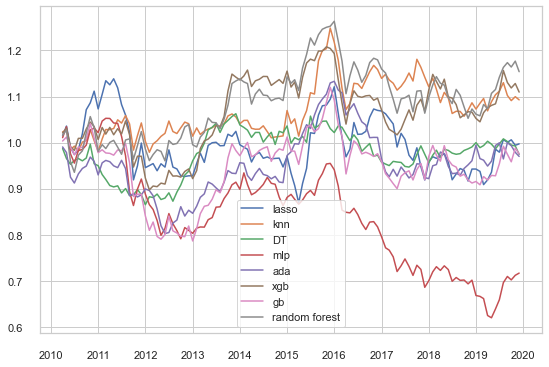

In [9]:
plt.plot(p_lasso['cum_ret'],label='lasso')
plt.plot(p_knn['cum_ret'],label='knn')
plt.plot(p_tree['cum_ret'],label='DT')
plt.plot(p_mlp['cum_ret'],label='mlp')
plt.plot(p_ada['cum_ret'],label='ada')
plt.plot(p_xgb['cum_ret'],label='xgb')
plt.plot(p_gb['cum_ret'],label='gb')
plt.plot(p_rf['cum_ret'],label='random forest')
plt.legend()
plt.show()

#### Up&Downs

Logistics:


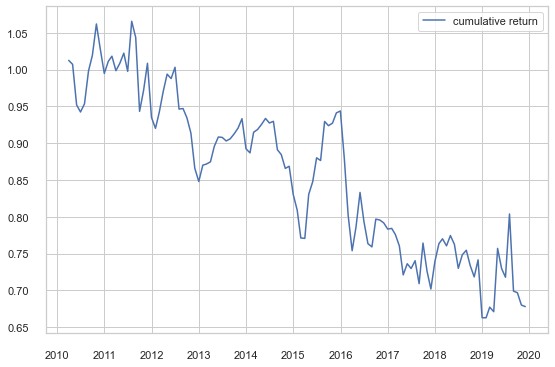

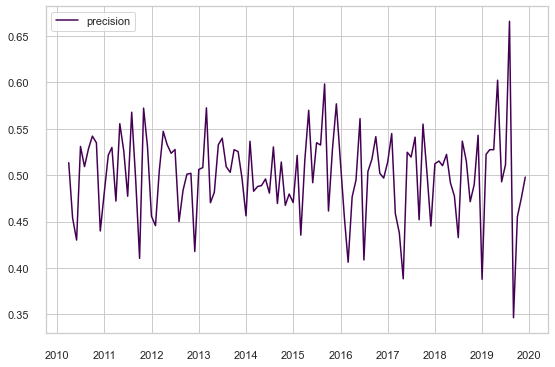

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


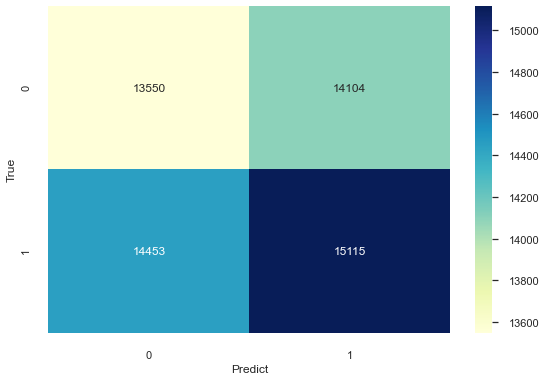

Annual_ret: -0.0330410258709047 

Sharpe Ratio: -0.28943434429484394 

Max_drawdown: 0.18347806372400421
KNN:


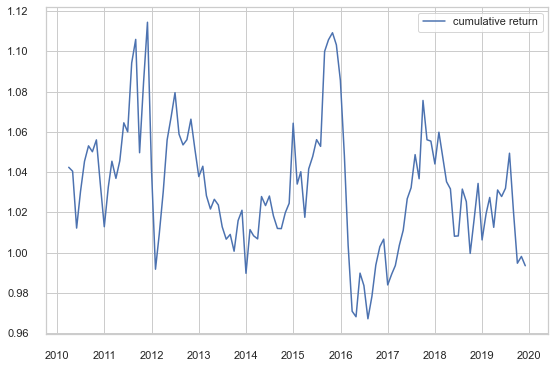

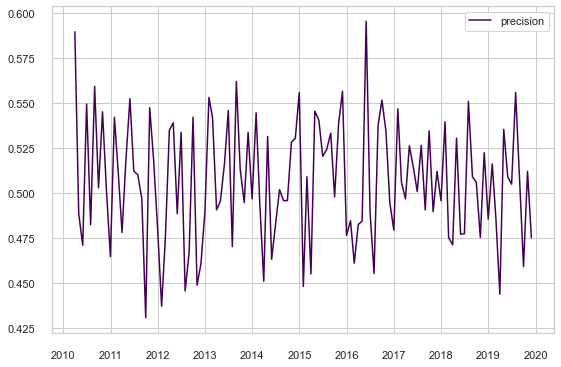

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


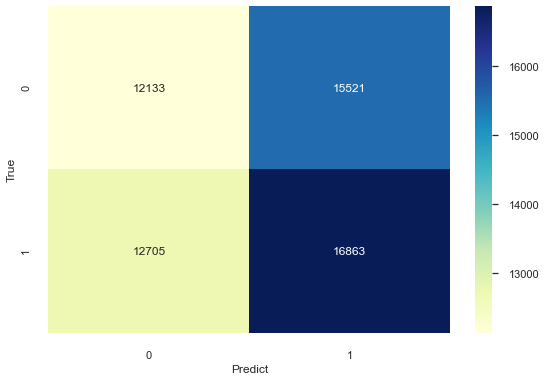

Annual_ret: -0.0006726886461481153 

Sharpe Ratio: -0.009623923017718786 

Max_drawdown: 0.10778791420811762
MLP:


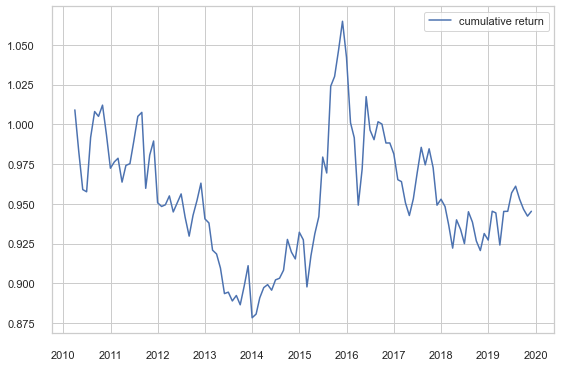

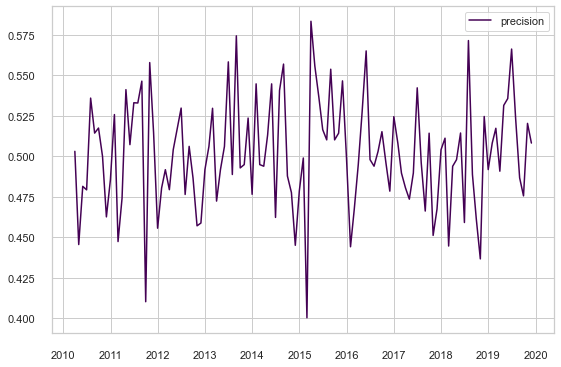

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


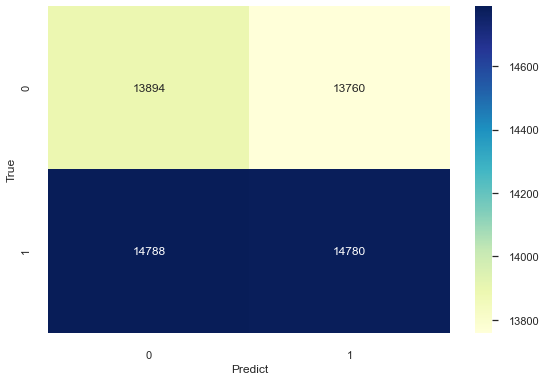

Annual_ret: -0.005655728536192884 

Sharpe Ratio: -0.09694459097019166 

Max_drawdown: 0.1752006876497143
Decition Trees:


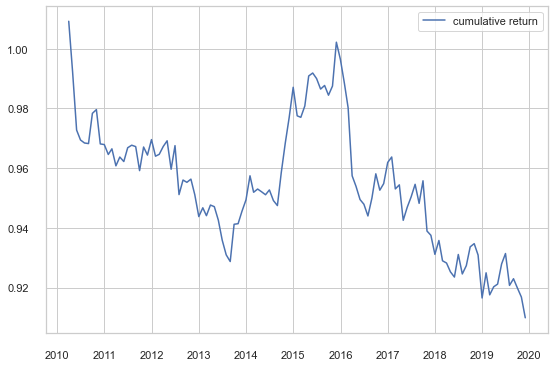

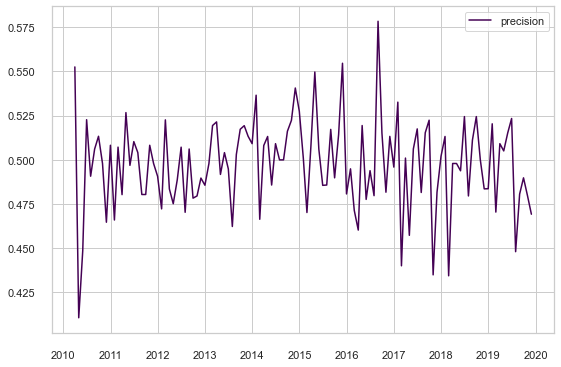

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


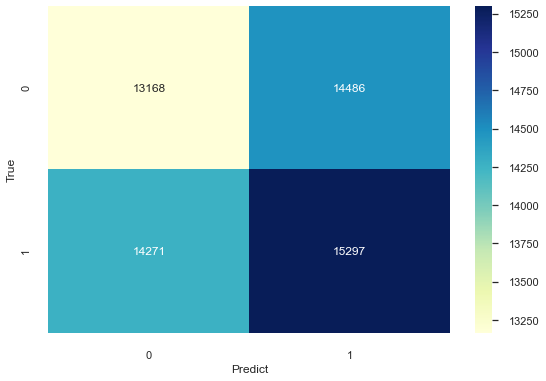

Annual_ret: -0.009241493678135579 

Sharpe Ratio: -0.387087061083811 

Max_drawdown: 0.07330935193594856
AdaBoost:


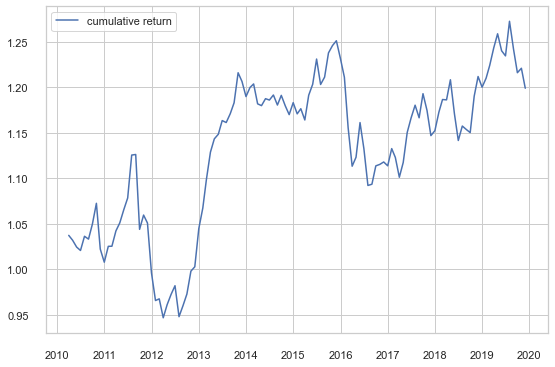

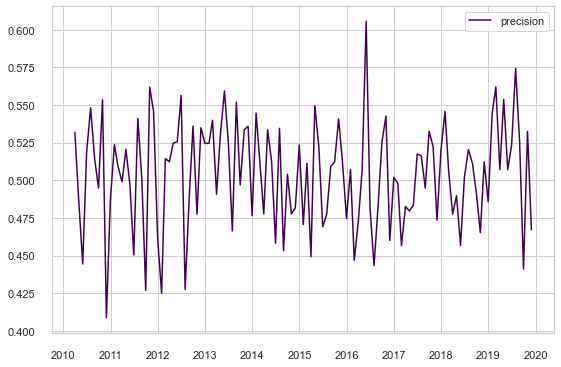

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


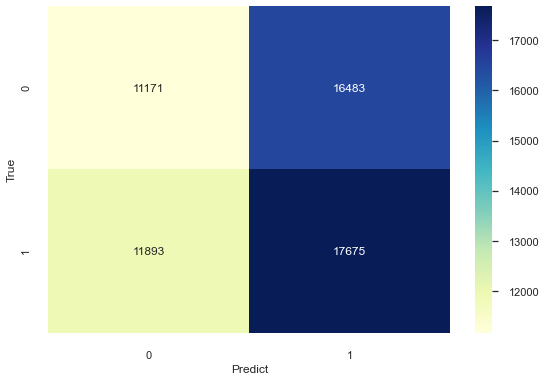

Annual_ret: 0.02040947744070616 

Sharpe Ratio: 0.26120297271924886 

Max_drawdown: 0.25602137747431675
XGBoost:


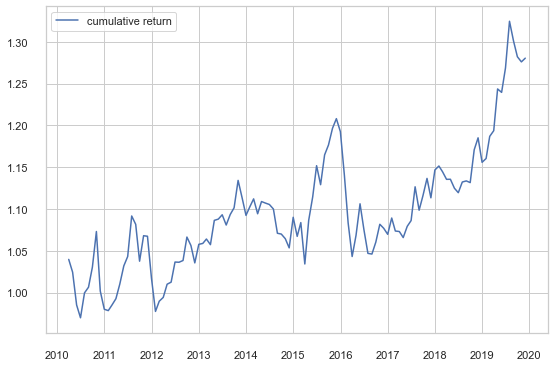

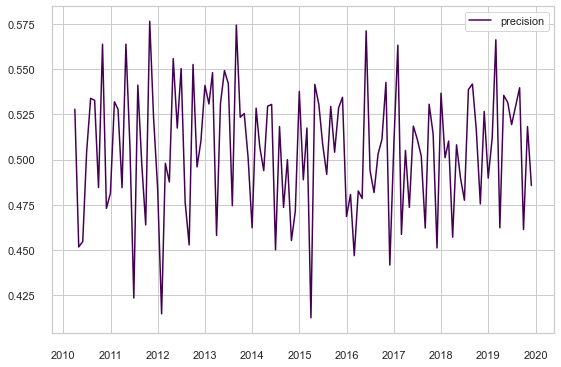

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


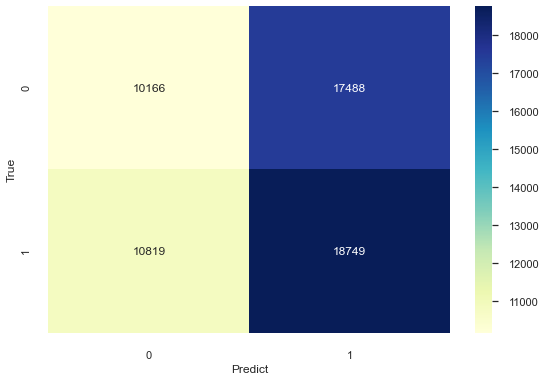

Annual_ret: 0.028763071279019472 

Sharpe Ratio: 0.3346854716267191 

Max_drawdown: 0.26781867534974846
Gradient Boost:


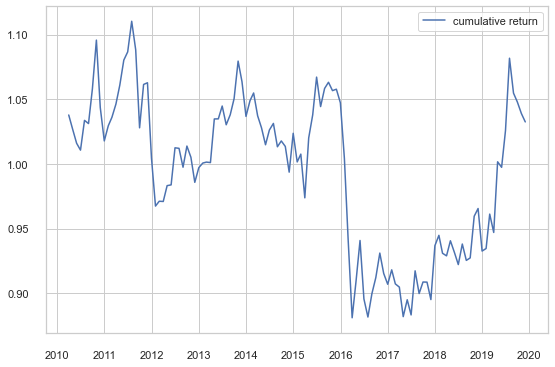

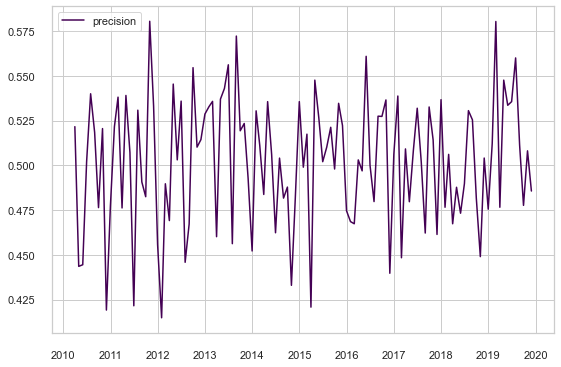

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


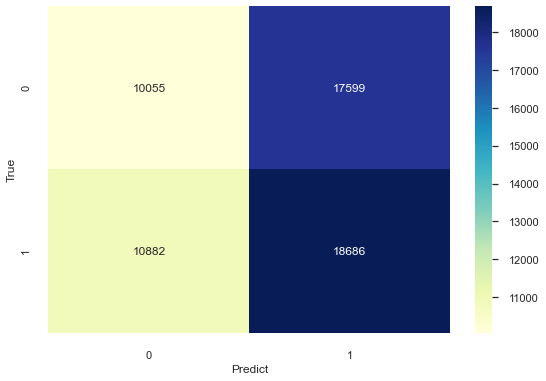

Annual_ret: 0.0033360676085368874 

Sharpe Ratio: 0.04087471692435703 

Max_drawdown: 0.1856509614717653
Random Forest:


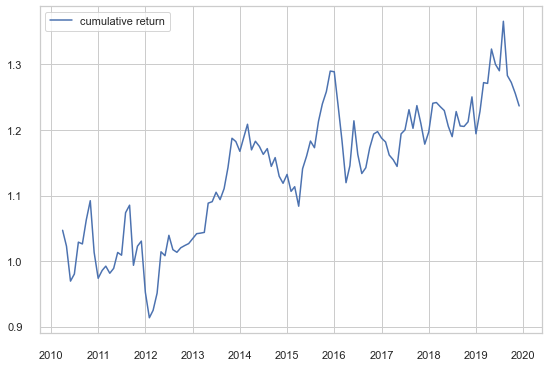

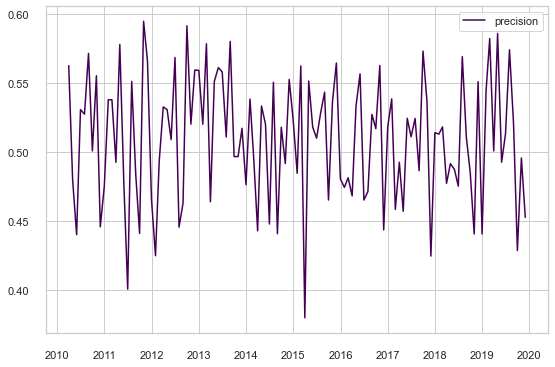

Confusion Matrix: (x-axis is the predicted labels and y-axis is the true label)


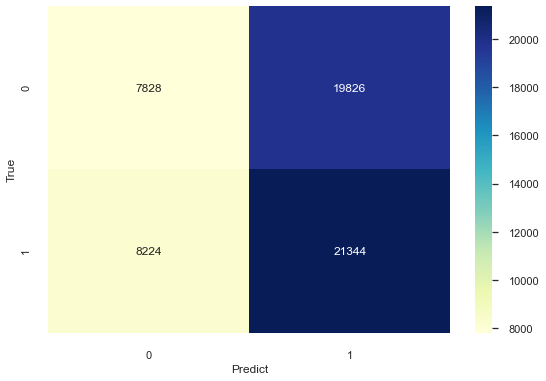

Annual_ret: 0.02426952269310286 

Sharpe Ratio: 0.21426490850153884 

Max_drawdown: 0.331189273882881


In [10]:
print('Logistics:')
model =  model =  LogisticRegressionCV(Cs=np.linspace(0.00001,0.001,100),cv=5,fit_intercept=False,penalty='l2',multi_class='multinomial')
p_log = backtest_rolling(features_after,model,keyword='up_down')

print('KNN:')
knn = KNeighborsClassifier(n_neighbors=50)
p_knn = backtest_rolling(features_after,knn,keyword='up_down')

print('MLP:')
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,3), random_state=1)
p_mlp = backtest_rolling(features_after,mlp,keyword='up_down')

print("Decition Trees:")
tree = DecisionTreeClassifier(random_state=0)
p_tree = backtest_rolling(features_after,tree,keyword='up_down')

print('AdaBoost:')
model = AdaBoostClassifier(random_state=0, n_estimators=100)
p_ada = backtest_rolling(features_after,model,keyword='up_down')

print('XGBoost:')
model = XGBClassifier()
p_xgb = backtest_rolling(features_after,model,keyword='up_down')

print('Gradient Boost:')
model = GradientBoostingClassifier(random_state=0, n_estimators=100)
p_gb = backtest_rolling(features_after,model,keyword='up_down')

print('Random Forest:')
model = RandomForestClassifier(max_depth=4, n_estimators=100, max_features='auto')
p_rf = backtest_rolling(features_after,model,keyword='up_down')

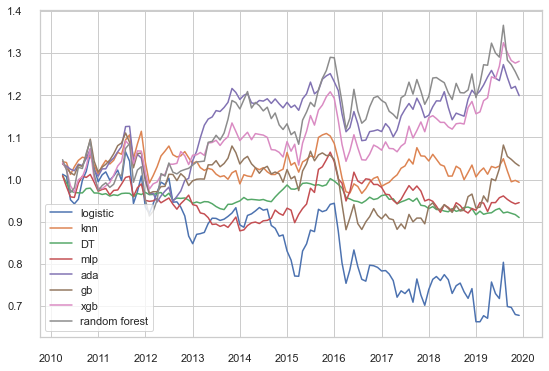

In [11]:
plt.plot(p_log['cum_ret'],label='logistic')
plt.plot(p_knn['cum_ret'],label='knn')
plt.plot(p_tree['cum_ret'],label='DT')
plt.plot(p_mlp['cum_ret'],label='mlp')
plt.plot(p_ada['cum_ret'],label='ada')
plt.plot(p_gb['cum_ret'],label='gb')
plt.plot(p_xgb['cum_ret'],label='xgb')
plt.plot(p_rf['cum_ret'],label='random forest')
plt.legend()
plt.show()

#### Deciles

In [ ]:
print('Logistics:')
model =  LogisticRegressionCV(Cs=np.linspace(0.00001,0.001,100),cv=5,fit_intercept=False,penalty='l2',multi_class='multinomial')
p_log = backtest_rolling(features_after,model,keyword='multi_class')

print('KNN:')
knn = KNeighborsClassifier(n_neighbors=50)
p_log = backtest_rolling(features_after,knn,keyword='multi_class')

print('MLP:')
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,3), random_state=1)
p_mlp = backtest_rolling(features_after,mlp,keyword='multi_class')

print("Decition Trees:")
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
p_tree = backtest_rolling(features_after,tree,keyword='multi_class')

print('AdaBoost:')
model = AdaBoostClassifier(random_state=0, n_estimators=100)
p_ada = backtest_rolling(features_after,model,keyword='multi_class')

print('XGBoost:')
model = XGBClassifier()
p_xgb = backtest_rolling(features_after,model,keyword='multi_class')

print('Gradient Boost:')
model = GradientBoostingClassifier(random_state=0, n_estimators=100)
p_gb = backtest_rolling(features_after,model,keyword='multi_class')

print('Random Forest:')
model = RandomForestClassifier(max_depth=4, n_estimators=100, max_features='auto')
p_rf = backtest_rolling(features_after,model,keyword='multi_class')

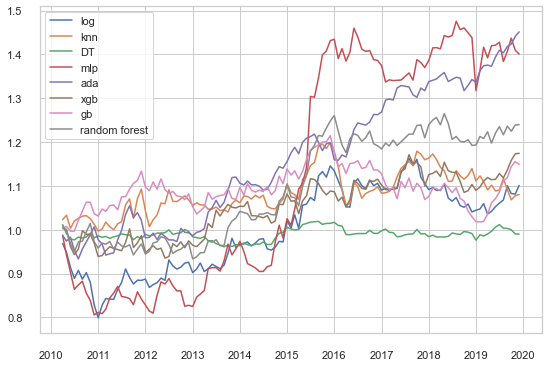

In [25]:
plt.plot(p_log['cum_ret'],label='log')
plt.plot(p_knn['cum_ret'],label='knn')
plt.plot(p_tree['cum_ret'],label='DT')
plt.plot(p_mlp['cum_ret'],label='mlp')
plt.plot(p_ada['cum_ret'],label='ada')
plt.plot(p_xgb['cum_ret'],label='xgb')
plt.plot(p_gb['cum_ret'],label='gb')
plt.plot(p_rf['cum_ret'],label='random forest')
plt.legend()
plt.show()